In [1]:
import json
import logging
import pandas as pd
import numpy as np

from sklearn.linear_model import RidgeCV, RANSACRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.model_selection import KFold
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin

from hdbscan import HDBSCAN

In [2]:
from data import POG4_Dataset

data = POG4_Dataset()

data.train.head()


INFO - Creating XML data
INFO - Creating activity data
INFO - Missing days: 3
INFO - Featurizing time series data
INFO - Creating interactions...


,date,sleep_hours,is_workday,day_of_week,AppleStandTime,slp_AppleStandTime_max_hrs_between,slp_AppleStandTime_sum_hrs_between,slp_AppleStandTime_startSleep_min_startDate_hr,slp_AppleStandTime_startSleep_max_startDate_hr,slp_AppleStandTime_startSleep_min_endDate_hr,...,slp_HeartRate_02_10_00,slp_HeartRate_07_45_00,RespiratoryRate,slp_RespiratoryRate_07_35_00,slp_RespiratoryRate_07_55_00,slp_RespiratoryRate_endSleep_max_startDate_hr,slp_RespiratoryRate_endSleep_max_endDate_hr,day_of_year,min_startDate_max_hr,min_endDate_max_hr
0,2021-10-25,7.691667,True,0,105.0,8.333333,7.250000,23.166667,24.000000,23.250000,...,52.0,41.50,874.5,14.750,16.5000,7.947500,7.947500,298,7.0,7.0
1,2021-10-26,7.358333,True,1,113.0,9.000000,7.916667,22.083333,24.166667,22.166667,...,53.0,50.00,868.0,15.000,15.0000,7.954722,7.954722,299,7.0,7.0
2,2021-10-27,5.775000,True,2,223.0,5.916667,5.666667,21.500000,24.250000,21.500000,...,50.0,76.75,787.5,18.000,18.0000,6.065278,6.065278,300,6.0,6.0
3,2021-10-28,8.666667,True,3,73.0,10.750000,17.750000,21.666667,21.666667,21.750000,...,48.0,47.00,896.5,13.875,13.5625,8.183333,8.183333,301,8.0,8.0
4,2021-10-29,8.508333,True,4,136.0,7.833333,13.083333,21.500000,23.500000,21.500000,...,55.0,52.00,961.0,14.500,15.7500,8.334722,8.334722,302,8.0,8.0


In [3]:


# Short time series data between 9/25/2020 and 11/30/2021 (with recent apple health data)
short_ts = data.train[(data.train['date'] >= pd.to_datetime('2020-09-25').date()) & (data.train['date'] <= pd.to_datetime('2021-11-30').date())]
short_ts['sleep_hours'] = short_ts['sleep_hours'].fillna(method="ffill").fillna(method="bfill").fillna(7.0)

short_ts.to_csv("short_ts.csv", index=False)
X_short = short_ts.drop(['sleep_hours'], axis=1)
y_short = short_ts['sleep_hours']


# Long time series data between 6/1/2015 and 11/30/2021
long_ts = data.train[(data.train['date'] >= pd.to_datetime('2015-06-01').date()) & (data.train['date'] <= pd.to_datetime('2021-11-30').date())]
X_long = X_short.copy() # long_ts.drop(['sleep_hours'], axis=1)
y_long = y_short.copy() # long_ts['sleep_hours'].fillna(method="ffill").fillna(method="bfill").fillna(7.0)

# Test data between 12/1/2021 and 12/31/2022
test = data.train[(data.train['date'] >= pd.to_datetime('2021-12-01').date()) & (data.train['date'] <= pd.to_datetime('2022-12-31').date())]
X_test = test.drop(['sleep_hours'], axis=1)
y_test = test['sleep_hours'].fillna(method="ffill").fillna(method="bfill").fillna(7.0)


In [4]:
# Check if X_test has same columns as X_short
(X_test.columns == X_short.columns).all()

(X_test.columns == X_long.columns).all()


True

In [5]:
imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()

class ClusteringTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.cluster = HDBSCAN()
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        self.cluster.fit(X)
        cluster_labels = self.cluster.labels_.reshape(-1, 1)
        self.scaler.fit(cluster_labels)
        return self

    def transform(self, X):
        cluster_labels = self.cluster.fit_predict(X).reshape(-1, 1)
        cluster_labels_scaled = self.scaler.transform(cluster_labels)
        X_new = np.column_stack((X, cluster_labels_scaled))
        return X_new

In [6]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """To remove date column and/or slp-prefixed columns for specified models"""
    def __init__(self, include_date = True, include_slp = True):
        self.include_date = include_date
        self.include_slp = include_slp

    def fit(self, X, y=None):
        self.dummy_fitted_ = True
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if not self.include_date and 'date' in X.columns:
            X = X.drop(columns=['date'])
        
        if not self.include_slp:
            slp_columns = [col for col in X.columns if col.startswith('slp')]
            X = X.drop(columns=slp_columns)
        
        return X

## Simple Models

In [7]:


# Original Dataset used for simple models
orig = pd.read_csv("./data/train.csv", low_memory=False)
orig["date"] = pd.to_datetime(orig["date"])
orig["day_of_week"] = orig["date"].dt.dayofweek
orig["is_workday"] = orig["day_of_week"] < 5
orig["day_of_year"] = orig["date"].dt.dayofyear

# Simple Models
class MedianDOWModel(BaseEstimator, RegressorMixin):
    """ Predict using median sleep hours for each day of the week"""
    def __init__(self):
        self.median_dow = orig.groupby("day_of_week")["sleep_hours"].median()
        self.global_mean = orig["sleep_hours"].mean() 
        pass

    def fit(self, X, y):
        # print('nans in median_dow:', np.isnan(MedianDOWModel().predict(X)).sum())
        self.dummy_fitted_ = True
        return self

    def predict(self, X):
        pred = X["day_of_week"].map(self.median_dow)
        return pred.to_numpy().ravel()

class MeanDOWModel(BaseEstimator, RegressorMixin):
    """ Predict using median sleep hours for each day of the week"""
    def __init__(self):
        self.mean_dow = orig.groupby("day_of_week")["sleep_hours"].mean()
        self.global_mean = orig["sleep_hours"].mean() 
        pass

    def fit(self, X, y):
        # print('nans in mean_dow:', np.isnan(MeanDOWModel().predict(X)).sum())
        self.dummy_fitted_ = True
        return self

    def predict(self, X):
        pred = X["day_of_week"].map(self.mean_dow)
        return pred.to_numpy().ravel()


class MedianWorkdayModel(BaseEstimator, RegressorMixin):
    """ Predict using median sleep hours for workdays and weekends"""
    def __init__(self):
        self.median_workday = orig.groupby("is_workday")["sleep_hours"].median()
        self.global_mean = orig["sleep_hours"].mean() 
        pass

    def fit(self, X, y):
        # print('nans in median_wd:', np.isnan(MedianWorkdayModel().predict(X)).sum())
        self.dummy_fitted_ = True
        return self

    def predict(self, X):
        pred = X["is_workday"].map(self.median_workday)
        return pred.to_numpy().ravel()

class MeanWorkdayModel(BaseEstimator, RegressorMixin):
    """ Predict using median sleep hours for workdays and weekends"""
    def __init__(self):
        self.mean_workday = orig.groupby("is_workday")["sleep_hours"].mean()
        self.global_mean = orig["sleep_hours"].mean() 
        pass

    def fit(self, X, y):
        # print('nans in mean_wd:', np.isnan(MeanWorkdayModel().predict(X)).sum())
        self.dummy_fitted_ = True
        return self

    def predict(self, X):
        pred = X["is_workday"].map(self.mean_workday)
        return pred.to_numpy().ravel()
    
class MeanDOYModel(BaseEstimator, RegressorMixin):
    """ Predict using mean sleep hours for each day of the year (1-365)"""
    def __init__(self):
        self.mean_day_of_year = orig.groupby("day_of_year")["sleep_hours"].mean()
        self.global_mean = orig["sleep_hours"].mean() # Sometimes issues with missing days of the year
        pass

    def fit(self, X, y):
        # print('nans in mean_doy_model:', np.isnan(MeanDOYModel().predict(X)).sum())
        self.dummy_fitted_ = True
        return self

    def predict(self, X):
        pred = X["day_of_year"].map(self.mean_day_of_year).fillna(self.global_mean)
        return pred.to_numpy().ravel()

median_dow = MedianDOWModel()
median_dow.fit(X_long, y_long)

mean_dow = MeanDOWModel()
mean_dow.fit(X_long, y_long)

median_wd = MedianWorkdayModel()
median_wd.fit(X_long, y_long)

mean_wd = MeanWorkdayModel()
mean_wd.fit(X_long, y_long)

mean_doy_model = MeanDOYModel()
mean_doy_model.fit(X_long, y_long)


simple_models = {
    'median_dow': median_dow,
    #'mean_dow': mean_dow,
    'median_wd': median_wd,
    #'mean_wd': mean_wd,
    'mean_doy_model': mean_doy_model
}

## Complex Regression Models

### Prophet by META

In [8]:
%%capture
!pip install prophet

In [9]:
from prophet import Prophet

with open("prophet_best_params.json", "r") as f:
    prophet_best_params = json.load(f)
    
print("Best Parameters for Prophet: ", prophet_best_params)

class ProphetModel(BaseEstimator, RegressorMixin):
    """ Predict using Prophet"""
    def __init__(self):
        logging.getLogger('fbprophet').setLevel(logging.ERROR)
        self.m = Prophet(**prophet_best_params)
        pass

    def fit(self, X, y):
        X = X.fillna(method="ffill").fillna(method="bfill").fillna(0) #Ok for Time Series
        X = X.rename(columns={'date': 'ds'})
        X["y"] = y
        
        # Add the additional regressors
        for col in [col for col in X.columns if col not in ["ds", "y"]]:
            self.m.add_regressor(col)
        
        self.m.fit(X)
        self.dummy_fitted_ = True
        return self

    def predict(self, X):
        X = X.fillna(method="ffill").fillna(method="bfill").fillna(0) #Ok for Time Series
        X = X.rename(columns={'date': 'ds', 'sleep_hours': 'y'})

        return self.m.predict(X)['yhat'].to_numpy().ravel()

prophet_model = ProphetModel()

prophet_model.fit(X_long, y_long)

INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG - input tempfile: /tmp/tmpd57_cnbi/5yotboik.json
DEBUG - input tempfile: /tmp/tmpd57_cnbi/op2qa698.json
DEBUG - idx 0
DEBUG - running CmdStan, num_threads: None
DEBUG - CmdStan args: ['/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38326', 'data', 'file=/tmp/tmpd57_cnbi/5yotboik.json', 'init=/tmp/tmpd57_cnbi/op2qa698.json', 'output', 'file=/tmp/tmpd57_cnbi/prophet_model8c3n5ddh/prophet_model-20230421175737.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:57:37 - cmdstanpy - INFO - Chain [1] start processing
INFO - Chain [1] start processing


Best Parameters for Prophet:  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 6, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


17:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO - Chain [1] done processing


ProphetModel()

### XGBoost

In [10]:
from xgboost import XGBRegressor

with open("xgb_best_params.json", "r") as f:
    xgb_best_params = json.load(f)
    
print("Best Parameters for XGBoost: ", xgb_best_params)

xgb_params = {
    "learning_rate": xgb_best_params["learning_rate"],
    "max_depth": xgb_best_params["max_depth"],
    'lambda': xgb_best_params["lmbda"],
    'alpha': xgb_best_params["alpha"],
    "n_estimators": xgb_best_params["n_estimators"],
    "subsample": xgb_best_params["subsample"],
    "colsample_bytree": xgb_best_params["colsample_bytree"],
    "objective": "reg:squarederror",
    "seed": 42
}

xgb_model = XGBRegressor(**xgb_params, 
                            gpu_id=0, 
                            tree_method="gpu_hist",
                            random_state=42
                            )

xgb_pipeline = Pipeline([
    ("date_filter", ColumnDropper(include_date=False, include_slp=True)),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', RobustScaler()),
    ('cluster',ClusteringTransformer()),
    ('xgb', xgb_model)
])

xgb_pipeline.fit(X_short, y_short)

Best Parameters for XGBoost:  {'alpha': 0.15500515308718543, 'lmbda': 9.4553069371423, 'scaler': 'minmax', 'imputer': 'most_frequent', 'max_depth': 64, 'subsample': 0.3388935978957399, 'n_estimators': 6148, 'learning_rate': 0.2994369042411531, 'colsample_bytree': 0.4745469122792432}


Pipeline(steps=[('date_filter', ColumnDropper(include_date=False)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('cluster', ClusteringTransformer()),
                ('xgb',
                 XGBRegressor(alpha=0.15500515308718543, base_score=None,
                              booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.4745469122792432,
                              early_...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              lambda=9.4553069371423,
                              learning_rate=0.2994369042411531, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=64,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=6148, n_jobs=None,
                              num_parallel_tree=None, ...))])

### Extra Trees

In [11]:
from sklearn.ensemble import ExtraTreesRegressor

with open("et_best_params.json", "r") as f:
    et_best_params = json.load(f)
    
print("Best Parameters for ExtraTrees: ", et_best_params)

et_params = {
    "n_estimators": et_best_params["n_estimators"],
    "max_depth": et_best_params["max_depth"],
    "min_samples_split": et_best_params["min_samples_split"],
    "min_samples_leaf": et_best_params["min_samples_leaf"],
}

et_model = ExtraTreesRegressor(**et_params, random_state=42)

et_pipeline = Pipeline([
    ("date_filter", ColumnDropper(include_date=False, include_slp=True)),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', RobustScaler()),
    ('cluster',ClusteringTransformer()),
    ('et', et_model)
])

et_pipeline.fit(X_short, y_short)

Best Parameters for ExtraTrees:  {'scaler': 'minmax', 'imputer': 'median', 'max_depth': 11, 'n_estimators': 1305, 'min_samples_leaf': 1, 'min_samples_split': 2}


Pipeline(steps=[('date_filter', ColumnDropper(include_date=False)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('cluster', ClusteringTransformer()),
                ('et',
                 ExtraTreesRegressor(max_depth=11, n_estimators=1305,
                                     random_state=42))])

### K Nearest Neighbors

In [12]:
from sklearn.neighbors import KNeighborsRegressor

with open("knn_best_params.json", "r") as f:
    knn_best_params = json.load(f)
    
print("Best Parameters for KNN: ", knn_best_params)

knn_params = {
    "n_neighbors": knn_best_params["n_neighbors"],
    "weights": knn_best_params["weights"],
    "p": knn_best_params["p"]
}

knn_model = KNeighborsRegressor(**knn_params)

knn_pipeline = Pipeline([
    ("date_filter", ColumnDropper(include_date=False, include_slp=True)),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', RobustScaler()),
    ('cluster',ClusteringTransformer()),
    ('knn', knn_model)
])

knn_pipeline.fit(X_short, y_short)

Best Parameters for KNN:  {'p': 1, 'scaler': 'standard', 'imputer': 'median', 'weights': 'distance', 'n_neighbors': 17}


Pipeline(steps=[('date_filter', ColumnDropper(include_date=False)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('cluster', ClusteringTransformer()),
                ('knn',
                 KNeighborsRegressor(n_neighbors=17, p=1, weights='distance'))])

### Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

with open("rf_best_params.json", "r") as f:
    rf_best_params = json.load(f)

print("Best Parameters for RF: ", rf_best_params)

rf_params = {
    "n_estimators": rf_best_params["n_estimators"],
    "max_depth": rf_best_params["max_depth"],
    "min_samples_split": rf_best_params["min_samples_split"],
    "min_samples_leaf": rf_best_params["min_samples_leaf"]
}

rf_model = RandomForestRegressor(**rf_params, random_state=42, n_jobs=-1)

rf_pipeline = Pipeline([
    ("date_filter", ColumnDropper(include_date=False, include_slp=True)),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', RobustScaler()),
    ('cluster',ClusteringTransformer()),
    ('rf', rf_model)
])

rf_pipeline.fit(X_short, y_short)


Best Parameters for RF:  {'scaler': 'minmax', 'imputer': 'most_frequent', 'max_depth': 96, 'max_features': 'auto', 'n_estimators': 1320, 'min_samples_leaf': 1, 'min_samples_split': 6}


Pipeline(steps=[('date_filter', ColumnDropper(include_date=False)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('cluster', ClusteringTransformer()),
                ('rf',
                 RandomForestRegressor(max_depth=96, min_samples_split=6,
                                       n_estimators=1320, n_jobs=-1,
                                       random_state=42))])

### GRU Model

In [15]:
from gru import TimeSeriesDataset, GRUModel, GRUTrainer

import torch
import torch.nn as nn
from torch.optim import Adam, SGD, RMSprop, AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

with open("gru_best_params.json", "r") as f:
    gru_best_params = json.load(f)

print("Best Parameters for GRU: ", gru_best_params)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # CUDA support

input_size = X_long.shape[1] - len([col for col in X_long.columns if col.startswith("slp")]) # Minus 1 for date, +1 for sleep hours, minus 14 for sleep features




gru_target_scaler = RobustScaler() 
gru_model = GRUModel(device, input_size,
                     gru_best_params["hidden_size"],
                     gru_best_params["num_layers"],
                     1,
                     gru_best_params["dropout_rate"],
                     gru_best_params["activation_function"]).to(device)
gru_trainer = GRUTrainer(gru_model, device,
                         gru_best_params["learning_rate"], 
                         gru_best_params["criterion"], 
                         gru_best_params["optimizer"], 
                         None)

class NNModel(BaseEstimator, RegressorMixin):
    """ Predict using Prophet"""
    def __init__(self, lookback, batch_size, target_scaler, model, trainer, num_epochs=500):
        self.lookback = lookback
        self.batch_size = batch_size
        
        self.target_scaler = target_scaler
        
        self.model = model
        
        self.output_size = 1
        self.num_epochs = num_epochs
        self.trainer = trainer
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # CUDA support

        pass

    def fit(self, X, y):
        X = pd.DataFrame(X)
        
        if not isinstance(y, np.ndarray):
            y = y.to_numpy().reshape(-1, 1)
        else:
            y = y.reshape(-1, 1)
        
        y_scaled = self.target_scaler.fit_transform(y)
        y_scaled = pd.DataFrame(y_scaled, columns=["sleep_hours"])
        
        train = pd.concat([X, y_scaled], axis=1).to_numpy() # X is already scaled
        train_ds = TimeSeriesDataset(train, self.lookback, self.output_size)
        train_dl = DataLoader(train_ds, batch_size=self.batch_size, shuffle=False)
        
        for epoch in range(self.num_epochs):
            train_loss = self.trainer.train(train_dl)
            val_loss = self.trainer.evaluate(train_dl)
        
        print(f"Final Epoch {epoch+1}, train_loss: {train_loss:.4f}, valid_rmse: {val_loss:.4f}")
        
        self.dummy_fitted_ = True
        return self

    def predict(self, X):
        num_predictions = X.shape[0]
        X = torch.from_numpy(X).float() #.to_numpy()
        y_pred = self.trainer.predict(X, self.lookback, 1, num_predictions)
        y_pred = self.target_scaler.inverse_transform(y_pred) # Inverse scaling is used to calculate validation RMSE

        return np.nan_to_num(y_pred, nan=7.0).ravel()


GRU = NNModel(gru_best_params["lookback"], gru_best_params["batch_size"], gru_target_scaler, gru_model, gru_trainer)

GRU_pipeline = Pipeline([
    ("date_filter", ColumnDropper(include_date=False, include_slp=False)),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', RobustScaler()),
    ('gru', GRU)
])

GRU_pipeline.fit(X_long, y_long)
# Final Epoch 500, train_loss: 0.6226, valid_rmse: 0.8497

Best Parameters for GRU:  {'lookback': 1, 'criterion': 'mae', 'optimizer': 'adamw', 'batch_size': 210, 'num_epochs': 291, 'num_layers': 1, 'hidden_size': 287, 'dropout_rate': 0.5964791189037534, 'learning_rate': 0.007953492092921025, 'activation_function': 'sigmoid'}
Final Epoch 500, train_loss: 0.6814, valid_rmse: 0.8754


Pipeline(steps=[('date_filter',
                 ColumnDropper(include_date=False, include_slp=False)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('gru',
                 NNModel(batch_size=210, lookback=1,
                         model=GRUModel(
  (gru): GRU(9, 287, batch_first=True, bidirectional=True)
  (layer_norm): LayerNorm((574,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5964791189037534, inplace=False)
  (fc): Linear(in_features=574, out_features=1, bias=True)
),
                         target_scaler=RobustScaler(),
                         trainer=<gru.GRUTrainer object at 0x7f78e7709d30>))])

### LSTM Model

In [17]:

with open("lstm_best_params.json", "r") as f:
    lstm_best_params = json.load(f)
    
print("Best Parameters for LSTM: ", lstm_best_params)

from lstm import TimeSeriesDataset, LSTMModel, LSTMTrainer

lstm_target_scaler = RobustScaler() 
lstm_model = LSTMModel(device, input_size,
                     lstm_best_params["hidden_size"],
                     lstm_best_params["num_layers"],
                     1,
                     lstm_best_params["dropout_rate"],
                     lstm_best_params["activation_function"]).to(device)
lstm_trainer = LSTMTrainer(lstm_model, device,
                         lstm_best_params["learning_rate"], 
                         lstm_best_params["criterion"], 
                         lstm_best_params["optimizer"], 
                         None)



LSTM = NNModel(lstm_best_params["lookback"], lstm_best_params["batch_size"], lstm_target_scaler, lstm_model, lstm_trainer)

LSTM_pipeline = Pipeline([
    ("date_filter", ColumnDropper(include_date=False, include_slp=False)),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', RobustScaler()),
    ('lstm', LSTM)
])

LSTM_pipeline.fit(X_long, y_long)

Best Parameters for LSTM:  {'lookback': 13, 'criterion': 'huber', 'optimizer': 'adamw', 'batch_size': 51, 'num_epochs': 497, 'num_layers': 1, 'hidden_size': 55, 'dropout_rate': 0.5632208872024901, 'learning_rate': 0.0003492454573360324, 'activation_function': 'linear'}
Final Epoch 500, train_loss: 0.0790, valid_rmse: 0.2984


Pipeline(steps=[('date_filter',
                 ColumnDropper(include_date=False, include_slp=False)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('lstm',
                 NNModel(batch_size=51, lookback=13,
                         model=LSTMModel(
  (LSTM): LSTM(9, 55, batch_first=True)
  (layer_norm): LayerNorm((55,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5632208872024901, inplace=False)
  (fc): Linear(in_features=55, out_features=1, bias=True)
),
                         target_scaler=RobustScaler(),
                         trainer=<lstm.LSTMTrainer object at 0x7f784becc2e0>))])

## Complex Classification Models

### XGBoost - Classification

In [18]:
from xgboost import XGBClassifier

with open("xgb_classifier_best_params.json", "r") as f:
    xgb_classifier_best_params = json.load(f)
    
print("Best Parameters for XGBoost: ", xgb_classifier_best_params)

xgb_clf_params = {
    "learning_rate": xgb_classifier_best_params["learning_rate"],
    "max_depth": xgb_classifier_best_params["max_depth"],
    'lambda': xgb_classifier_best_params["lmbda"],
    'alpha': xgb_classifier_best_params["alpha"],
    "n_estimators": xgb_classifier_best_params["n_estimators"],
    "subsample": xgb_classifier_best_params["subsample"],
    "colsample_bytree": xgb_classifier_best_params["colsample_bytree"],
    'eta': xgb_classifier_best_params["eta"],
    "objective": "reg:squarederror",
    "seed": 42
}

class XGBClassifierModel(BaseEstimator, RegressorMixin):
    """ Predicts Median unless high probability of above or below median"""
    def __init__(self):
        self.model = XGBClassifier(**xgb_clf_params, gpu_id=0, tree_method="gpu_hist", random_state=42)
        pass

    def fit(self, X, y):
        self.y_med = np.median(y)
        self.y_std = y.std()
        self.y_low = self.y_med - 1*self.y_std
        self.y_high = self.y_med + 1*self.y_std
        
        y_classifier = (y > self.y_med).astype(int)
        self.model.fit(X, y_classifier)
        self.dummy_fitted_ = True
        return self

    def predict(self, X):
        probabilities = self.model.predict_proba(X)[:, 1]
        preds = np.array([self.y_high if x > 0.75 else 
                          (self.y_low if x < 0.25 else 
                           self.y_med) 
                          for x in probabilities])
        return preds.ravel()

xgb_clf_model = XGBClassifierModel()

xgb_clf_pipeline = Pipeline([
    ("date_filter", ColumnDropper(include_date=False, include_slp=False)),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', RobustScaler()),
    ('cluster',ClusteringTransformer()),
    ('xgb_clf', xgb_clf_model)
])

xgb_clf_pipeline.fit(X_long, y_long)

Best Parameters for XGBoost:  {'eta': 0.2189867593417301, 'alpha': 1.798190574808438, 'lmbda': 3.8748760484151914, 'scaler': 'minmax', 'imputer': 'median', 'max_depth': 3, 'subsample': 0.5256694730321446, 'n_estimators': 1642, 'learning_rate': 0.1682025111157145, 'colsample_bytree': 0.6490424765035034}


Pipeline(steps=[('date_filter',
                 ColumnDropper(include_date=False, include_slp=False)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('cluster', ClusteringTransformer()),
                ('xgb_clf', XGBClassifierModel())])

### XGBoost - Sleep Times

In [19]:
import pytz
import datetime

with open("sleep_model_best_params.json", "r") as f:
    sleep_model_best_params = json.load(f)
    
print("Best Parameters for XGBoost Sleep Model: ", sleep_model_best_params)

xgb_params = {
    "learning_rate": sleep_model_best_params["learning_rate"],
    "max_depth": sleep_model_best_params["max_depth"],
    "n_estimators": sleep_model_best_params["n_estimators"],
    "subsample": sleep_model_best_params["subsample"],
    "colsample_bytree": sleep_model_best_params["colsample_bytree"],
    "gamma": sleep_model_best_params["gamma"],
    "min_child_weight": sleep_model_best_params["min_child_weight"],
    "objective": "binary:logistic",
    "seed": 42
}

class XGBSleepTimesModel(BaseEstimator, RegressorMixin):
    """ Predict using median sleep hours for workdays and weekends"""
    def __init__(self, data_path, data_name):
        self.model = XGBClassifier(**xgb_clf_params, gpu_id=0, tree_method="gpu_hist", random_state=42)
        
        self.data_path = data_path
        self.data_name = data_name
        
        self.df_sleep = pd.read_csv('./data/train_detailed.csv', low_memory=False)
        self.df_sleep = self._process_sleep_data(self.df_sleep)
        
        self.lags = 60
        
        self.df_hr = pd.read_csv(self.data_path, low_memory=False)
        self.df_hr = self._preprocess_feature_data(self.df_hr, self.data_name, smoothing = 2, freq="1min", start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00')
        self.df_hr = self._create_lags(self.df_hr, self.data_name, self.lags)
        
        self.expanded_data  = pd.merge(self.df_sleep, self.df_hr, on='date', how='outer')
        self.expanded_data  = self.expanded_data.set_index("date")
        self.expanded_data  = self.expanded_data.astype('float32')
        self.expanded_data  = self.expanded_data.fillna(method='ffill').fillna(method='bfill')
        
        pass
    
    def _process_sleep_data(self, df, freq='1min', start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00'):
        #exclude where valud is HKCategoryValueSleepAnalysisInBed
        df = df.drop(df[df['value'] == 'HKCategoryValueSleepAnalysisInBed'].index)
        
        # Parse dates and times
        df['startDate'] = pd.to_datetime(df['startDate'])
        df['endDate'] = pd.to_datetime(df['endDate'])

        # Create the date range
        expanded_df = pd.DataFrame()
        expanded_df["date"] = pd.date_range(start_date, end_date, freq=freq, tz=pytz.FixedOffset(-240))

        # 1 if between startDate and endDate, 0 otherwise
        expanded_df["value"] = 0
        for _, row in df.iterrows():
            mask = (expanded_df['date'] >= row['startDate']) & (expanded_df['date'] <= row['endDate'])
            expanded_df.loc[mask, 'value'] = 1
            
        expanded_df = expanded_df.rename(columns={'value': 'sleep'})

        return expanded_df
    
    def _preprocess_feature_data(self, df, col_name, freq='1min', smoothing = 2, start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00'):
        df = df[(df['startDate'] >= start_date) & (df['startDate'] <= end_date)]
        
        df = pd.melt(df, id_vars=['value'], value_vars=['startDate', 'endDate'], value_name='date')
        df = df.groupby('date', as_index=False).mean(numeric_only=True)
        df = df.sort_values(by='date')
        
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        df = df.resample(freq).mean()
        
        df = df.interpolate().rolling(smoothing).mean()
        df = df.fillna(method="bfill")
        
        df = df.reset_index()
        df = df.rename(columns={'date': 'date', 'value': col_name})
        
        return df

    def _create_lags(self, df, column_name, n_lags):
        bckwd_columns = [df[column_name].shift(i).fillna(method="bfill").fillna(method="ffill") for i in range(1, n_lags+1)]
        fwd_columns = [df[column_name].shift(-i).fillna(method="bfill").fillna(method="ffill") for i in range(1, n_lags+1)]
        bckwd_names = [f"{column_name}_bckwd_{i}" for i in range(1, n_lags+1)]
        fwd_names = [f"{column_name}_fwd_{i}" for i in range(1, n_lags+1)]
        df_lags = pd.concat(bckwd_columns + fwd_columns, axis=1, keys=bckwd_names + fwd_names)
        return pd.concat([df, df_lags], axis=1)

    def fit(self, X, y):
        min_date = X['date'].min()
        max_date = X['date'].max()
        
        timezone = pytz.FixedOffset(-240)
        min_date = datetime.datetime.combine(min_date, datetime.time()).replace(tzinfo=timezone)
        max_date = datetime.datetime.combine(max_date, datetime.time()).replace(tzinfo=timezone)

                                                            
        train = self.expanded_data[(self.expanded_data.index >= min_date) & (self.expanded_data.index <= max_date)]
        X, y = train.drop(columns=["sleep"]), train["sleep"]

        self.scaler = RobustScaler()
        
        self.pipeline = Pipeline(steps=[("scaler", self.scaler), ("model", self.model)])
        self.pipeline.fit(X, y)
        self.dummy_fitted_ = True
        return self

    def predict(self, X):
        min_date = X.date.min() - datetime.timedelta(days=2)
        max_date = X.date.max() + datetime.timedelta(days=2)

        timezone = pytz.FixedOffset(-240)
        min_date = datetime.datetime.combine(min_date, datetime.time()).replace(tzinfo=timezone)
        max_date = datetime.datetime.combine(max_date, datetime.time()).replace(tzinfo=timezone)
        
        model_data = self.expanded_data[(self.expanded_data.index >= min_date) & (self.expanded_data.index <= max_date)]
        model_data = model_data.drop(columns=["sleep"], errors='ignore')
        
        preds = self.pipeline.predict_proba(model_data)[:, 1]
        
        preds = pd.DataFrame({"date": model_data.index.date, "sleep_prob": preds}) # Need to fix
        
        preds = preds.groupby("date")["sleep_prob"].sum().reset_index() # Sum Probabilities by date
        preds["sleep_prob"] = preds["sleep_prob"] * 1 / 60

        preds = pd.merge(X[['date']], preds, on='date', how='left')
        
        return preds.sleep_prob.fillna(7.0).to_numpy().ravel()




Best Parameters for XGBoost Sleep Model:  {'gamma': 0.7483232914389041, 'scaler': 'none', 'max_depth': 6, 'subsample': 0.6298206100536499, 'n_estimators': 830, 'learning_rate': 0.3017020376693815, 'colsample_bytree': 0.7979468286602337, 'min_child_weight': 5}


In [20]:
xgb_sleep_hr = XGBSleepTimesModel('./data/xml_export/HeartRate.csv', "hr").fit(X_short, y_short)

In [21]:
xgb_sleep_steps = XGBSleepTimesModel('./data/xml_export/StepCount.csv', "steps").fit(X_short, y_short)

In [22]:

xgb_sleep_dist = XGBSleepTimesModel('./data/xml_export/DistanceWalkingRunning.csv', "dist").fit(X_short, y_short)

In [23]:
sleep_models = {
    "xgb_sleep_hr": xgb_sleep_hr,
    "xgb_sleep_steps": xgb_sleep_steps,
    "xgb_sleep_dist": xgb_sleep_dist
}

In [24]:
# test = XGBSleepTimesModel()
# xgb_sleep_model.fit(X, y)
# xgb_sleep_model.predict(X)

### HR Model

In [25]:
complex_models = {
    'xgb': xgb_pipeline,
    'et': et_pipeline,
    'knn': knn_pipeline,
    'rf': rf_pipeline,
    'GRU': GRU_pipeline,
    'LSTM': LSTM_pipeline,
    'xgb_cf': xgb_clf_pipeline
}

In [26]:
kf = KFold(n_splits=3, shuffle=True, random_state=42) #tscv = TimeSeriesSplit(n_splits=5).split(data.X)


# Create pipelines for complex models
# complex_models_pipelines = {
#     model_name: Pipeline(steps=[("date_filter", ColumnDropper(include_date=False)),
#                                 ("imputer", SimpleImputer(strategy="median")),
#                                ("scaler", RobustScaler()),
#                                ('model', model)])
#     for model_name, model in complex_models.items()
# }


# Merge simple and complex models into a single dictionary and add prophet model
models = {**simple_models, 
          **complex_models, 
          **sleep_models,
          "prophet": prophet_model
          }

from sklearn.linear_model import Ridge, BayesianRidge

xgb = XGBRegressor(tree_method = 'gpu_hist', gpu_id = 0, random_state = 42)

stacked_regressor = StackingRegressor(estimators=list(models.items()), cv=kf, verbose=1, final_estimator=BayesianRidge())




In [27]:
stacked_regressor.fit(X_short, y_short)

Final Epoch 500, train_loss: 0.6814, valid_rmse: 0.8754
Final Epoch 500, train_loss: 0.0347, valid_rmse: 0.1627


INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG - input tempfile: /tmp/tmpd57_cnbi/5ig2zw00.json
DEBUG - input tempfile: /tmp/tmpd57_cnbi/9v9elb6x.json
DEBUG - idx 0
DEBUG - running CmdStan, num_threads: None
DEBUG - CmdStan args: ['/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66502', 'data', 'file=/tmp/tmpd57_cnbi/5ig2zw00.json', 'init=/tmp/tmpd57_cnbi/9v9elb6x.json', 'output', 'file=/tmp/tmpd57_cnbi/prophet_modeldnydf6z9/prophet_model-20230421180121.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:01:21 - cmdstanpy - INFO - Chain [1] start processing
INFO - Chain [1] start processing
18:01:21 - cmdstanpy - INFO - Chain [1] done processing
INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

Final Epoch 500, train_loss: 0.6821, valid_rmse: 0.8881
Final Epoch 500, train_loss: 0.6800, valid_rmse: 0.8802
Final Epoch 500, train_loss: 0.6481, valid_rmse: 0.8409


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Final Epoch 500, train_loss: 0.0212, valid_rmse: 0.0664
Final Epoch 500, train_loss: 0.0252, valid_rmse: 0.0838
Final Epoch 500, train_loss: 0.0299, valid_rmse: 0.0787


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - n_changepoints greater than number of observatio

StackingRegressor(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                  estimators=[('median_dow', MedianDOWModel()),
                              ('median_wd', MedianWorkdayModel()),
                              ('mean_doy_model', MeanDOYModel()),
                              ('xgb',
                               Pipeline(steps=[('date_filter',
                                                ColumnDropper(include_date=False)),
                                               ('imputer',
                                                SimpleImputer(strategy='median')),
                                               ('scaler', RobustScaler()),
                                               ('cluster',
                                                ClusteringTran...
                               XGBSleepTimesModel(data_name='hr',
                                                  data_path='./data/xml_export/HeartRate.csv')),
                              ('xgb_sleep_steps',
                               XGBSleepTimesModel(data_name='steps',
                                                  data_path='./data/xml_export/StepCount.csv')),
                              ('xgb_sleep_dist',
                               XGBSleepTimesModel(data_name='dist',
                                                  data_path='./data/xml_export/DistanceWalkingRunning.csv')),
                              ('prophet', ProphetModel())],
                  final_estimator=BayesianRidge(), verbose=1)

In [28]:
voting_regressor = VotingRegressor(estimators=list(models.items()), verbose=1)

voting_regressor.fit(X_short, y_short)

[Voting] .............. (1 of 14) Processing median_dow, total=   0.0s
[Voting] ............... (2 of 14) Processing median_wd, total=   0.0s
[Voting] .......... (3 of 14) Processing mean_doy_model, total=   0.0s
[Voting] ..................... (4 of 14) Processing xgb, total=   4.8s
[Voting] ...................... (5 of 14) Processing et, total=   0.7s
[Voting] ..................... (6 of 14) Processing knn, total=   0.0s
[Voting] ...................... (7 of 14) Processing rf, total=   2.2s
Final Epoch 500, train_loss: 0.6814, valid_rmse: 0.8754
[Voting] ..................... (8 of 14) Processing GRU, total=   1.5s
Final Epoch 500, train_loss: 0.0428, valid_rmse: 0.1600
[Voting] .................... (9 of 14) Processing LSTM, total=   1.0s
[Voting] ................. (10 of 14) Processing xgb_cf, total=   1.1s
[Voting] ........... (11 of 14) Processing xgb_sleep_hr, total=   2.6s
[Voting] ........ (12 of 14) Processing xgb_sleep_steps, total=   2.6s


INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG - input tempfile: /tmp/tmpd57_cnbi/1ucpkpla.json
DEBUG - input tempfile: /tmp/tmpd57_cnbi/ja_yqht2.json
DEBUG - idx 0
DEBUG - running CmdStan, num_threads: None
DEBUG - CmdStan args: ['/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39043', 'data', 'file=/tmp/tmpd57_cnbi/1ucpkpla.json', 'init=/tmp/tmpd57_cnbi/ja_yqht2.json', 'output', 'file=/tmp/tmpd57_cnbi/prophet_modelnetbi3vf/prophet_model-20230421181022.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
INFO - Chain [1] start processing


[Voting] ......... (13 of 14) Processing xgb_sleep_dist, total=   2.6s


18:10:22 - cmdstanpy - INFO - Chain [1] done processing
INFO - Chain [1] done processing


[Voting] ................ (14 of 14) Processing prophet, total=   0.3s


VotingRegressor(estimators=[('median_dow', MedianDOWModel()),
                            ('median_wd', MedianWorkdayModel()),
                            ('mean_doy_model', MeanDOYModel()),
                            ('xgb',
                             Pipeline(steps=[('date_filter',
                                              ColumnDropper(include_date=False)),
                                             ('imputer',
                                              SimpleImputer(strategy='median')),
                                             ('scaler', RobustScaler()),
                                             ('cluster',
                                              ClusteringTransformer()),
                                             ('xgb',
                                              XGBRegressor(alpha=0.1550051530871...
                                              XGBClassifierModel())])),
                            ('xgb_sleep_hr',
                             XGBSleepTimesModel(data_name='hr',
                                                data_path='./data/xml_export/HeartRate.csv')),
                            ('xgb_sleep_steps',
                             XGBSleepTimesModel(data_name='steps',
                                                data_path='./data/xml_export/StepCount.csv')),
                            ('xgb_sleep_dist',
                             XGBSleepTimesModel(data_name='dist',
                                                data_path='./data/xml_export/DistanceWalkingRunning.csv')),
                            ('prophet', ProphetModel())],
                verbose=1)

In [29]:
print('training R2: ', stacked_regressor.score(X_short, y_short))
#0.76
for model_name, coef in zip(models.keys(), stacked_regressor.final_estimator_.coef_):
    print(f'Model: {model_name:<15} {round(coef,4):<10}')

training R2:  0.6208463867719578
Model: median_dow      0.2522    
Model: median_wd       0.0506    
Model: mean_doy_model  -0.3266   
Model: xgb             0.1118    
Model: et              0.3342    
Model: knn             0.2631    
Model: rf              0.774     
Model: GRU             -0.0822   
Model: LSTM            -0.0059   
Model: xgb_cf          0.1795    
Model: xgb_sleep_hr    0.117     
Model: xgb_sleep_steps -0.0319   
Model: xgb_sleep_dist  -0.014    
Model: prophet         0.0821    


In [30]:
preds_stacked = stacked_regressor.predict(X_test)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds_stacked))
print("Stacked RMSE: %f" % (rmse))

Stacked RMSE: 1.182256


In [31]:
preds_voting = voting_regressor.predict(X_test)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds_voting))
print("Voting RMSE: %f" % (rmse))

Voting RMSE: 1.388198


In [32]:
xgb_pipeline.fit(X_short, y_short)

Pipeline(steps=[('date_filter', ColumnDropper(include_date=False)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('cluster', ClusteringTransformer()),
                ('xgb',
                 XGBRegressor(alpha=0.15500515308718543, base_score=None,
                              booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.4745469122792432,
                              early_...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              lambda=9.4553069371423,
                              learning_rate=0.2994369042411531, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=64,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=6148, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [33]:
df = pd.read_csv("./data/test.csv", low_memory=False)
df["date"] = pd.to_datetime(df["date"]).dt.date

df = df.merge(data.xml_data, on="date", how="left")
df = df.merge(data.activity_data, on="date", how="left") #Add Activity data
df = data._feature_engineering(df)


df = df[['date']+data.features.to_list()] # Keep only columns that are in the train data
print(df.columns)
sub = pd.DataFrame({"date": df["date"]}) # Create dataframe with date column from df

df = df.drop(columns=["sleep_hours"], errors = 'ignore') # Drop date column from df

preds = voting_regressor.predict(df) # predictions

# Create submission dataframe with date and predictions
sub["sleep_hours"] = preds


sub_stacked = sub.copy()
sub_stacked["sleep_hours"] = stacked_regressor.predict(df)


sub_avg = sub.copy()
sub_avg["sleep_hours"] = (sub["sleep_hours"] + sub_stacked["sleep_hours"]) / 2



sub_xgb = sub.copy()
sub_xgb["sleep_hours"] = xgb_pipeline.predict(df)

INFO - Featurizing time series data
INFO - Creating interactions...


Index(['date', 'is_workday', 'day_of_week', 'AppleStandTime',
       'slp_AppleStandTime_max_hrs_between',
       'slp_AppleStandTime_sum_hrs_between',
       'slp_AppleStandTime_startSleep_min_startDate_hr',
       'slp_AppleStandTime_startSleep_max_startDate_hr',
       'slp_AppleStandTime_startSleep_min_endDate_hr',
       'slp_AppleStandTime_startSleep_max_endDate_hr',
       'slp_AppleExerciseTime_max_hrs_between',
       'slp_AppleExerciseTime_sum_hrs_between', 'OxygenSaturation',
       'slp_OxygenSaturation_01_40_00', 'slp_ActiveEnergyBurned_23_35_00',
       'slp_ActiveEnergyBurned_23_45_00', 'slp_ActiveEnergyBurned_00_40_00',
       'slp_ActiveEnergyBurned_00_45_00', 'slp_ActiveEnergyBurned_01_15_00',
       'slp_ActiveEnergyBurned_01_30_00', 'slp_ActiveEnergyBurned_03_15_00',
       'slp_ActiveEnergyBurned_04_05_00', 'slp_ActiveEnergyBurned_05_25_00',
       'slp_BasalEnergyBurned_sum_hrs_between',
       'slp_BasalEnergyBurned_01_00_00', 'slp_HeartRate_01_50_00',
       'sl

In [37]:
sub_xgb.to_csv('submission_xgb.csv', index=False)
sub_avg.to_csv('submission_avg.csv', index=False)
sub_stacked.to_csv('submission_stacked.csv', index=False)

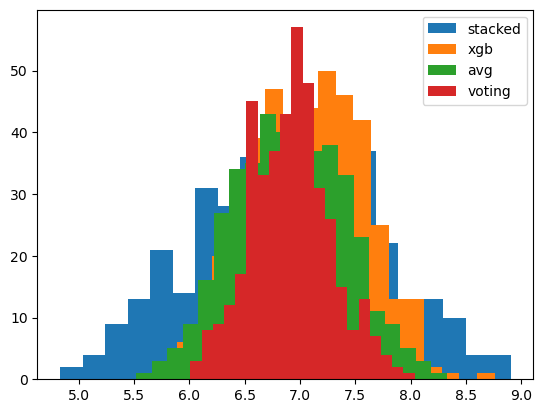

In [35]:
# plot sub and sub_copy sleep hours histograms
import matplotlib.pyplot as plt
plt.hist(sub_stacked["sleep_hours"], bins=20, label="stacked")
plt.hist(sub_xgb["sleep_hours"], bins=20, label="xgb")
plt.hist(sub_avg["sleep_hours"], bins=20, label="avg")
plt.hist(sub["sleep_hours"], bins=20, label="voting")

plt.legend()
plt.show()



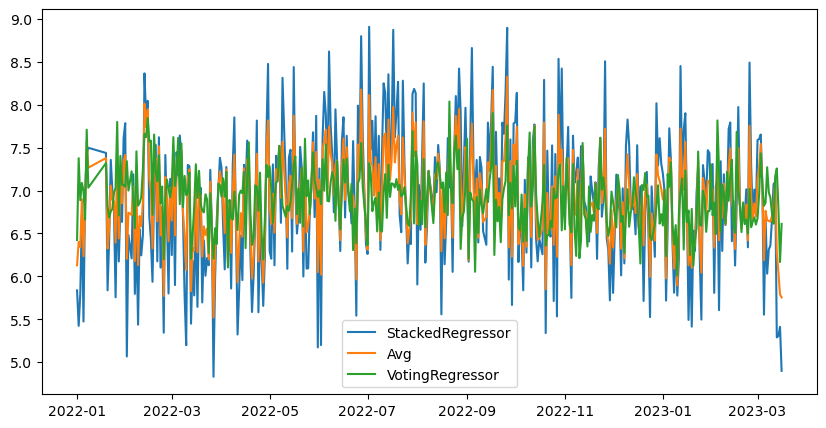

In [36]:
# plot sub and sub_copy sleep hours
plt.figure(figsize=(10, 5))
plt.plot(sub_stacked.date, sub_stacked.sleep_hours, label='StackedRegressor')
plt.plot(sub_avg.date, sub_avg.sleep_hours, label='Avg') # Dotted line
plt.plot(sub.date, sub.sleep_hours, label='VotingRegressor')
plt.legend()
plt.show()